In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject


In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
H5AD_V2_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv2", "20230630"
)
H5AD_V3_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv3", "20230630"
)


print(f"{'BASE_DIR':<15}{BASE_DIR}")
print(f"{'DATA_DIR':<15}{DATA_DIR}")
print(f"{'H5AD_V2_DIR':<15}{H5AD_V2_DIR}")
print(f"{'H5AD_V3_DIR':<15}{H5AD_V3_DIR}")

BASE_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject
DATA_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data
H5AD_V2_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630
H5AD_V3_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630


In [3]:
hy_v2_path = os.path.join(
    H5AD_V2_DIR,
    "WMB-10Xv2-HY-log2.h5ad"
)
hy_v3_path = os.path.join(
    H5AD_V3_DIR,
    "WMB-10Xv3-HY-log2.h5ad"
)

print(f"{'hy_v2_path':<15}{hy_v2_path}")
print(f"{'hy_v3_path':<15}{hy_v3_path}")

hy_v2_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad
hy_v3_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad


In [4]:
from src.utils import load_data
from src.clustering import ClusteringOptimization

import scanpy as sc
import matplotlib.pyplot as plt

In [5]:
hy_v2 = load_data(hy_v2_path, backed="r")
hy_v3 = load_data(hy_v3_path, backed="r")

--- Starting Preprocessing ---
Finding top 2500 highly variable genes...
Scaling data...


/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Performing PCA...
--- Preprocessing Complete ---

--- Running Optuna Optimization for 30 trials ---


  0%|          | 0/30 [00:00<?, ?it/s]


--- Optimization Complete ---
Best trial number: 21
Best Score (Calinski-Harabasz): 45556.6797
Best Parameters:
  dbscan__eps: 4.2799
  dbscan__min_samples: 49
  leiden__resolution: 0.2590
  neighbors__n_neighbors: 12

--- Applying Optimal Parameters to Data ---
1. Re-running preprocessing...


/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


2. Filtering noise with optimal DBSCAN parameters...
   Removed 4138 noise points.
   Retained 96424 cells for final clustering.
3. Running Leiden clustering on noise-filtered data...
4. Finalizing results...
5. Computing UMAP...

--- Final AnnData object is ready ---
Results are stored in:
  - `adata.obs['dbscan_labels']`: Noise classification from DBSCAN.
  - `adata.obs['optimized_leiden']`: Final Leiden clusters after noise removal.
  - `adata.obsm['X_umap']`: UMAP on all cells.
  - `adata.obsm['X_umap_filtered']`: UMAP on non-noise cells only.

--- Visualizing Final Results ---


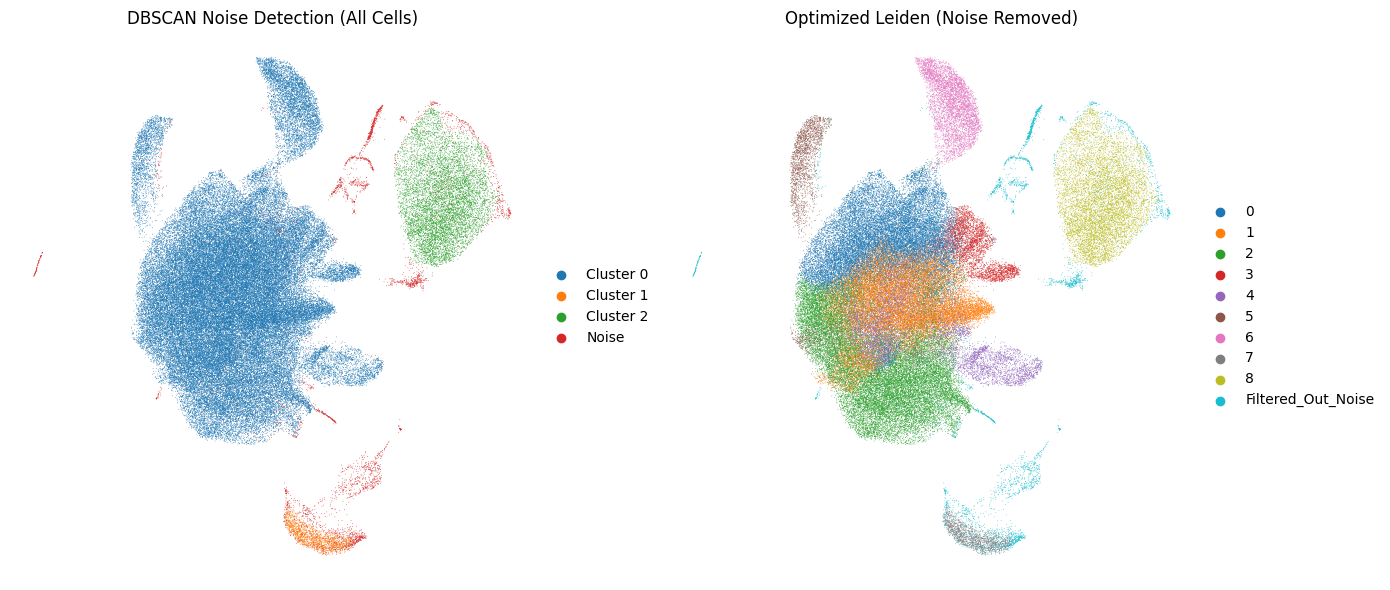

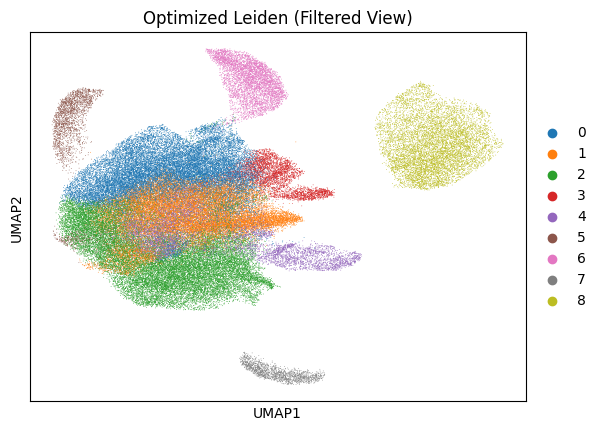

In [ ]:
adata = hy_v2.to_memory()

optimizer = ClusteringOptimization(
    adata=adata,
    genes_to_clust=("top", 2_500),
    tune_dbscan=True,
    tune_leiden=True,
    tune_neighbors=True,
)
optimizer.run_optimization(n_trials=30) 
best_params = optimizer.get_best_params()
final_adata = optimizer.apply_best_params()
print("\n--- Visualizing Final Results ---")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc.pl.umap(
    final_adata, 
    color='dbscan_labels', 
    ax=axes[0], 
    show=False, 
    frameon=False,
    title='DBSCAN Noise Detection (All Cells)'
)

sc.pl.umap(
    final_adata, 
    color='optimized_leiden', 
    ax=axes[1], 
    show=False, 
    frameon=False,
    title='Optimized Leiden (Noise Removed)',
    na_color='lightgray'
)

plt.tight_layout()
plt.show()


adata_clean = final_adata[final_adata.obs['optimized_leiden'] != 'Filtered_Out_Noise'].copy()
sc.pl.umap(adata_clean, color='optimized_leiden', title='Optimized Leiden (Filtered View)')


In [ ]:
import gc

del adata
del final_adata
del adata_clean

gc.collect()

25189